# ARIMA/Garch MODELING--WORKFLOW IMPROVED ON QCOM(Qualcomm) STOCKS/SECURITIES

Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import yfinance as yf
from datetime import datetime,timedelta

Load data --'SPY'

In [2]:
df=yf.download(tickers='QCOM',start='2015-01-01',end='2025-12-20',auto_adjust=False)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,QCOM,QCOM,QCOM,QCOM,QCOM,QCOM
Date,,,,,,
2015-01-02,54.334961,74.279999,74.870003,73.750000,74.510002,6662700
2015-01-05,54.078930,73.930000,74.500000,73.629997,73.709999,12042800
2015-01-06,53.310875,72.879997,74.610001,72.739998,73.860001,11094000
2015-01-07,53.932636,73.730003,74.470001,72.959999,73.370003,10030700
2015-01-08,54.503220,74.510002,75.300003,74.139999,74.300003,10937200


Clean

In [3]:
df.columns=df.columns.droplevel(1)
df.columns.name=None
df.sort_index()
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,54.334961,74.279999,74.870003,73.750000,74.510002,6662700
2015-01-05,54.078930,73.930000,74.500000,73.629997,73.709999,12042800
2015-01-06,53.310875,72.879997,74.610001,72.739998,73.860001,11094000
2015-01-07,53.932636,73.730003,74.470001,72.959999,73.370003,10030700
2015-01-08,54.503220,74.510002,75.300003,74.139999,74.300003,10937200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2759 entries, 2015-01-02 to 2025-12-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2759 non-null   float64
 1   Close      2759 non-null   float64
 2   High       2759 non-null   float64
 3   Low        2759 non-null   float64
 4   Open       2759 non-null   float64
 5   Volume     2759 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 150.9 KB


Values already follow DateTimeIndex and seem sorted

We will only use Adj Close

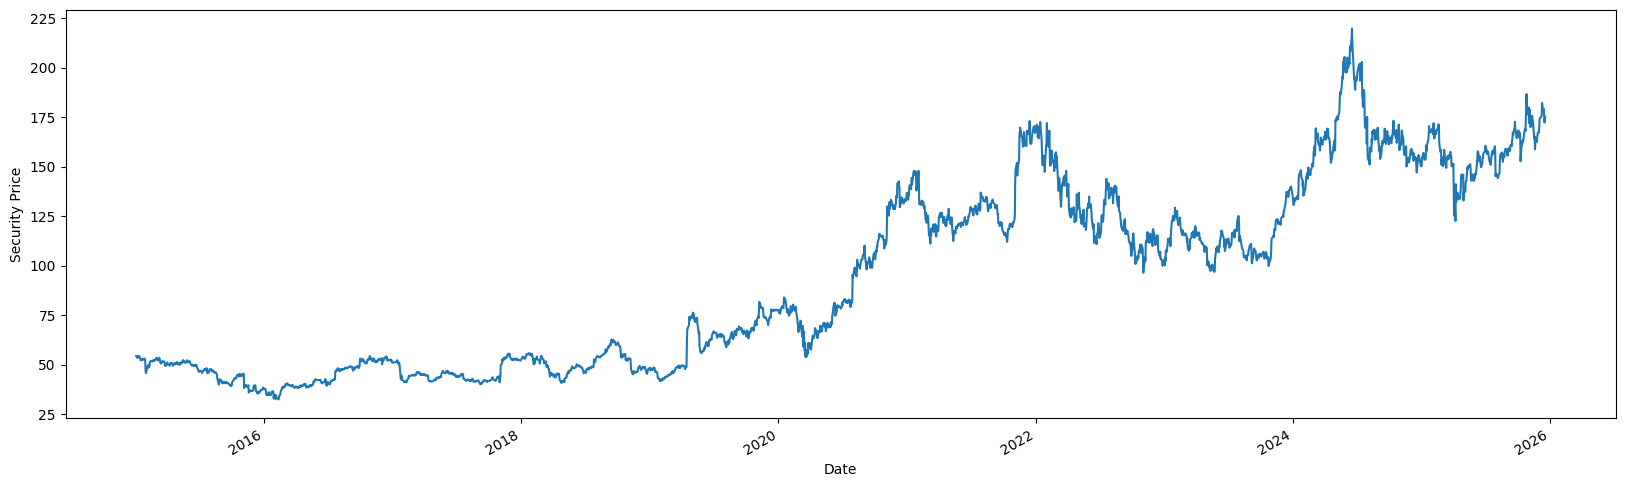

In [5]:
price_chart=df['Adj Close']
price_chart.plot(figsize=(20,6))
plt.ylabel('Security Price')
plt.show()

### For ARIMA we will resample data to get stock adjusted closing prices aggregated on a weekly basis and get returns on the same time plane/frame and log-difference of weekly closes.

In [6]:
week=df.resample('W').mean()
week=week[['Adj Close']]
week.head()

,Adj Close
Date,
2015-01-04,54.334961
2015-01-11,54.052602
2015-01-18,52.876367
2015-01-25,52.696428
2015-02-01,49.963585


Weekly returns / log-difference of weekly closes.

In [7]:
week['weeklyr']=np.log(week[['Adj Close']]).diff()
week.dropna(inplace=True)
week[['weeklyr']].head()

,weeklyr
Date,
2015-01-11,-0.005210
2015-01-18,-0.022001
2015-01-25,-0.003409
2015-02-01,-0.053253
2015-02-08,-0.023014


In [8]:
week.tail()

,Adj Close,weeklyr
Date,,
2025-11-23,163.327451,-0.059006
2025-11-30,164.556667,0.007498
2025-12-07,172.071591,0.044656
2025-12-14,178.616000,0.037328
2025-12-21,175.431998,-0.017987


In [9]:
week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 572 entries, 2015-01-11 to 2025-12-21
Freq: W-SUN
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  572 non-null    float64
 1   weeklyr    572 non-null    float64
dtypes: float64(2)
memory usage: 13.4 KB


Train/Test

In [10]:
train=week[:569]
# There is no need for test because we will directly compare,
# the future predictions with the info we have. Therefore, we 
# will predict the weeks that we already know about and then 
# see if the predictions are accurate/overlapping.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 569 entries, 2015-01-11 to 2025-11-30
Freq: W-SUN
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  569 non-null    float64
 1   weeklyr    569 non-null    float64
dtypes: float64(2)
memory usage: 13.3 KB


Lets look at overall fluctuations/changes on weekly closing bases

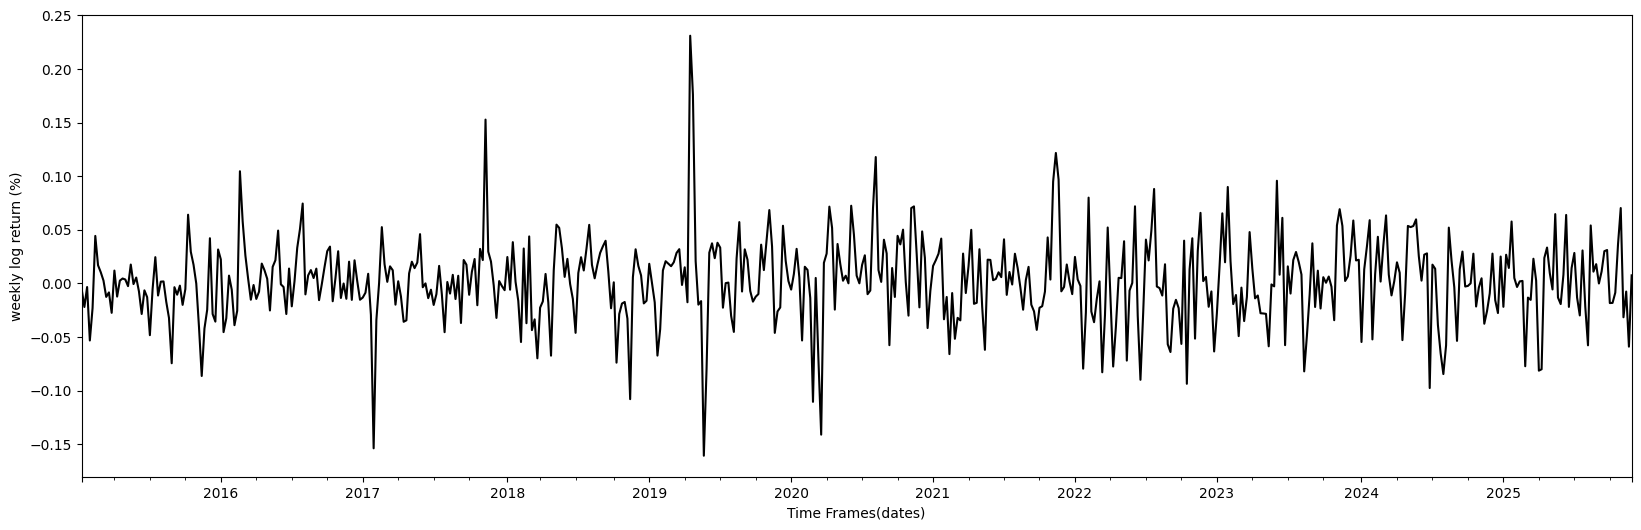

In [12]:
plt.figure(figsize=(20,6))
train['weeklyr'].plot(kind='line',color='black')
plt.xlabel('Time Frames(dates)')
plt.ylabel('weekly log return (%)')
plt.show()

In [13]:
logdiffwc=train[['weeklyr']]

In [14]:
logdiffwc

,weeklyr
Date,
2015-01-11,-0.005210
2015-01-18,-0.022001
2015-01-25,-0.003409
2015-02-01,-0.053253
2015-02-08,-0.023014
...,...
2025-11-02,0.070249
2025-11-09,-0.031603
2025-11-16,-0.007631


Test for stationarity of the weeklyr returns which signify the total profit/loss on a weekly basis(at the end of the week.)

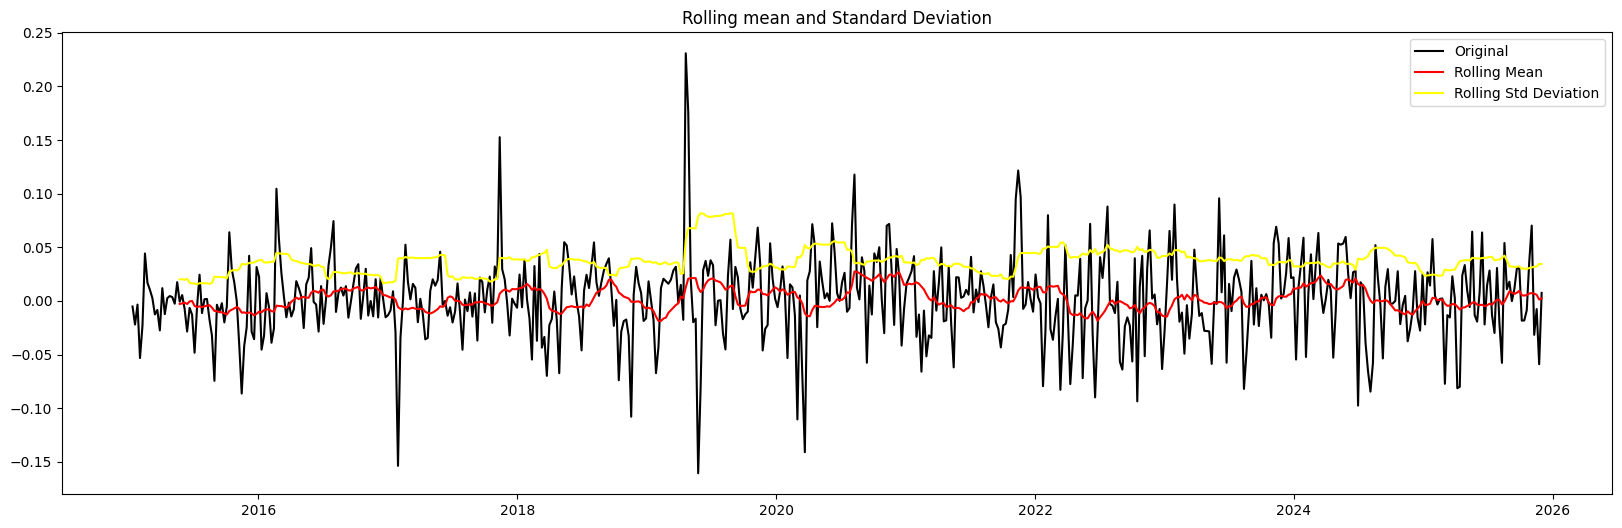

In [15]:
rolling_mean=logdiffwc.rolling(20).mean()
rolling_std=logdiffwc.rolling(20).std()
plt.figure(figsize=(20,6))
orig=plt.plot(logdiffwc,color='black',label='Original')
mean=plt.plot(rolling_mean,color='red',label='Rolling Mean')
std=plt.plot(rolling_std,color='yellow',label='Rolling Std Deviation')
plt.title('Rolling mean and Standard Deviation')
plt.legend(loc='best')
plt.show()

Dickey-Fuller Test to verify stationarity

In [16]:
dftest=sm.tsa.adfuller(logdiffwc[['weeklyr']],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=[['Test Statistic','p-vlaue','#Lags used','Number of Observations used']])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)]=value

dfoutput

Test Statistic                -1.156177e+01
p-vlaue                        3.257230e-21
#Lags used                     4.000000e+00
Number of Observations used    5.640000e+02
Critical Value (1%)           -3.441998e+00
Critical Value (5%)           -2.866678e+00
Critical Value (10%)          -2.569506e+00
dtype: float64

p-value<0.05, stationarity of data confirmed, null hypothesis rejected

Decide on hyperparameters by looking at ACF and PACF charts.

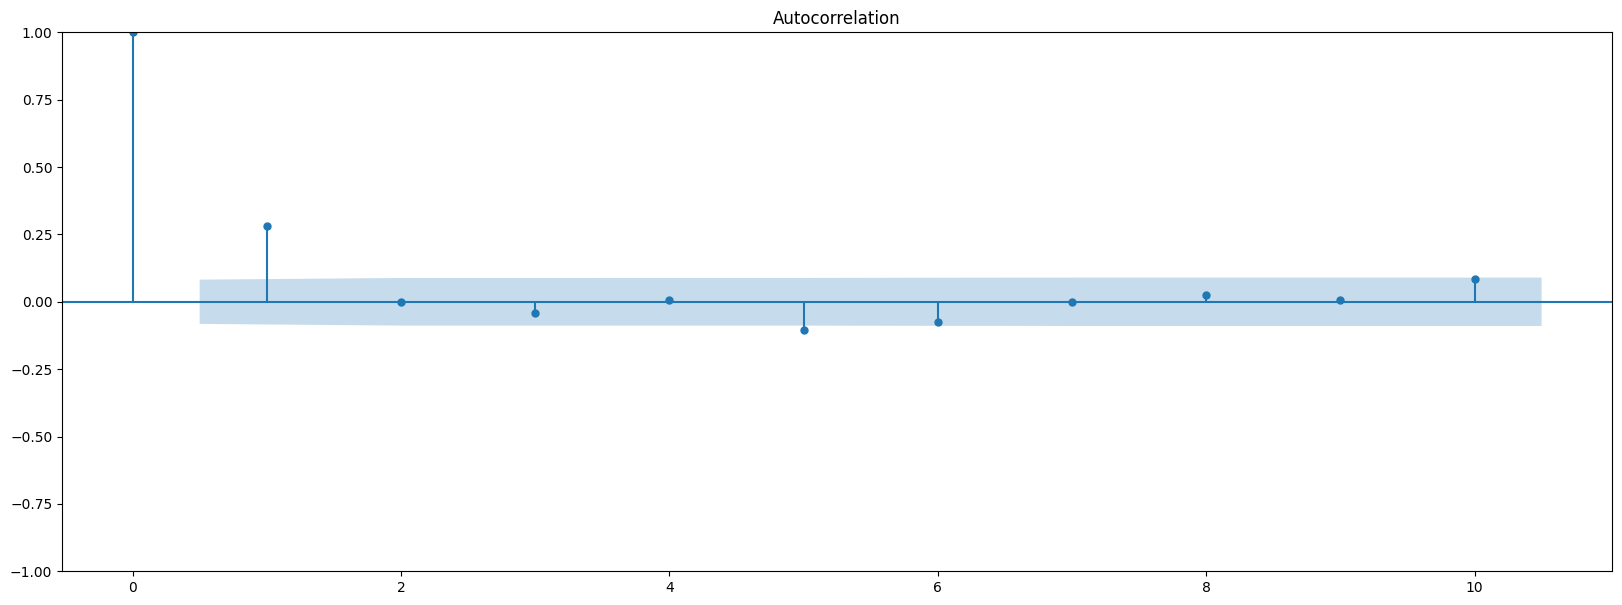

In [17]:
fig,ax=plt.subplots(figsize=(20,7))
plot_acf(logdiffwc.values,lags=10,ax=ax)
plt.show()

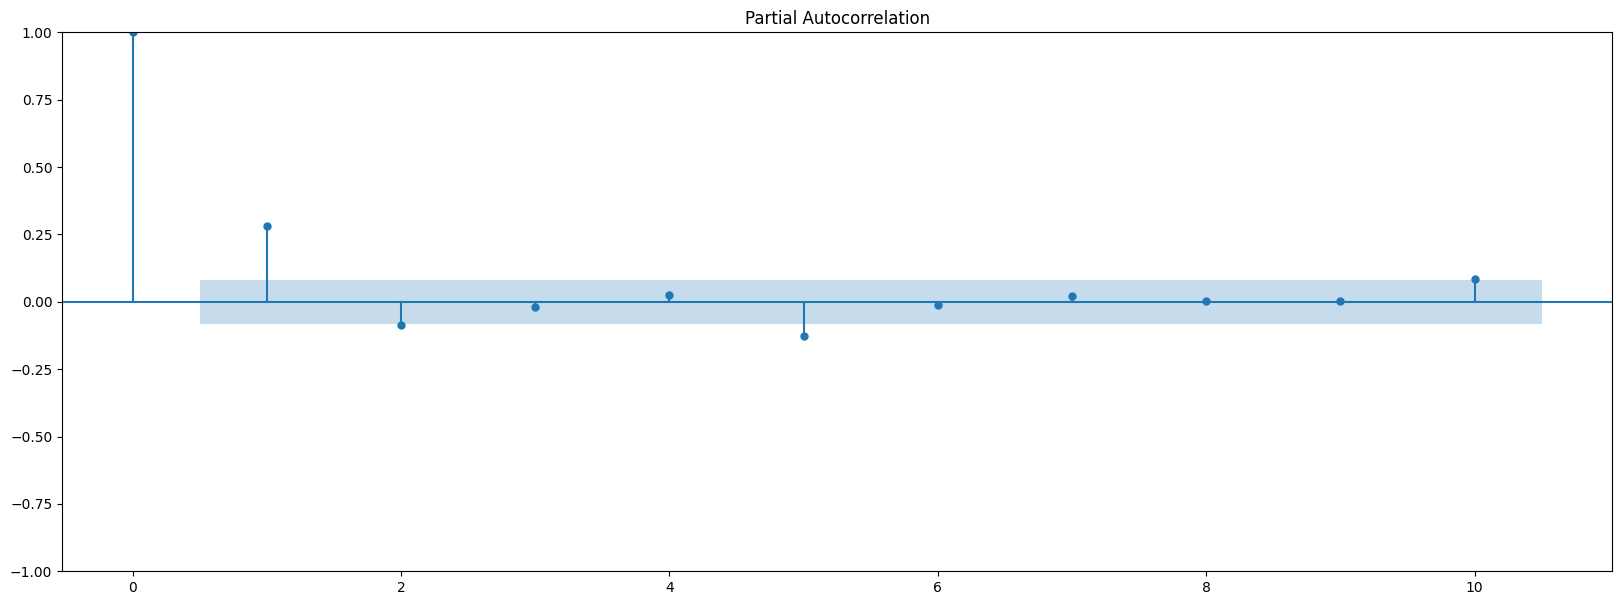

In [18]:
fig,ax=plt.subplots(figsize=(20,7))
plot_pacf(logdiffwc.values,lags=10,ax=ax)
plt.show()

Evaluation Metric -- AIC

ARIMA

In [19]:
ar1=ARIMA(logdiffwc.values,order=(0,0,1),trend='n').fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  569
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1062.525
Date:                Fri, 26 Dec 2025   AIC                          -2121.051
Time:                        00:14:32   BIC                          -2112.363
Sample:                             0   HQIC                         -2117.661
                                - 569                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2922      0.032      9.234      0.000       0.230       0.354
sigma2         0.0014   4.81e-05     29.076      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               369.55
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC: -2121.051

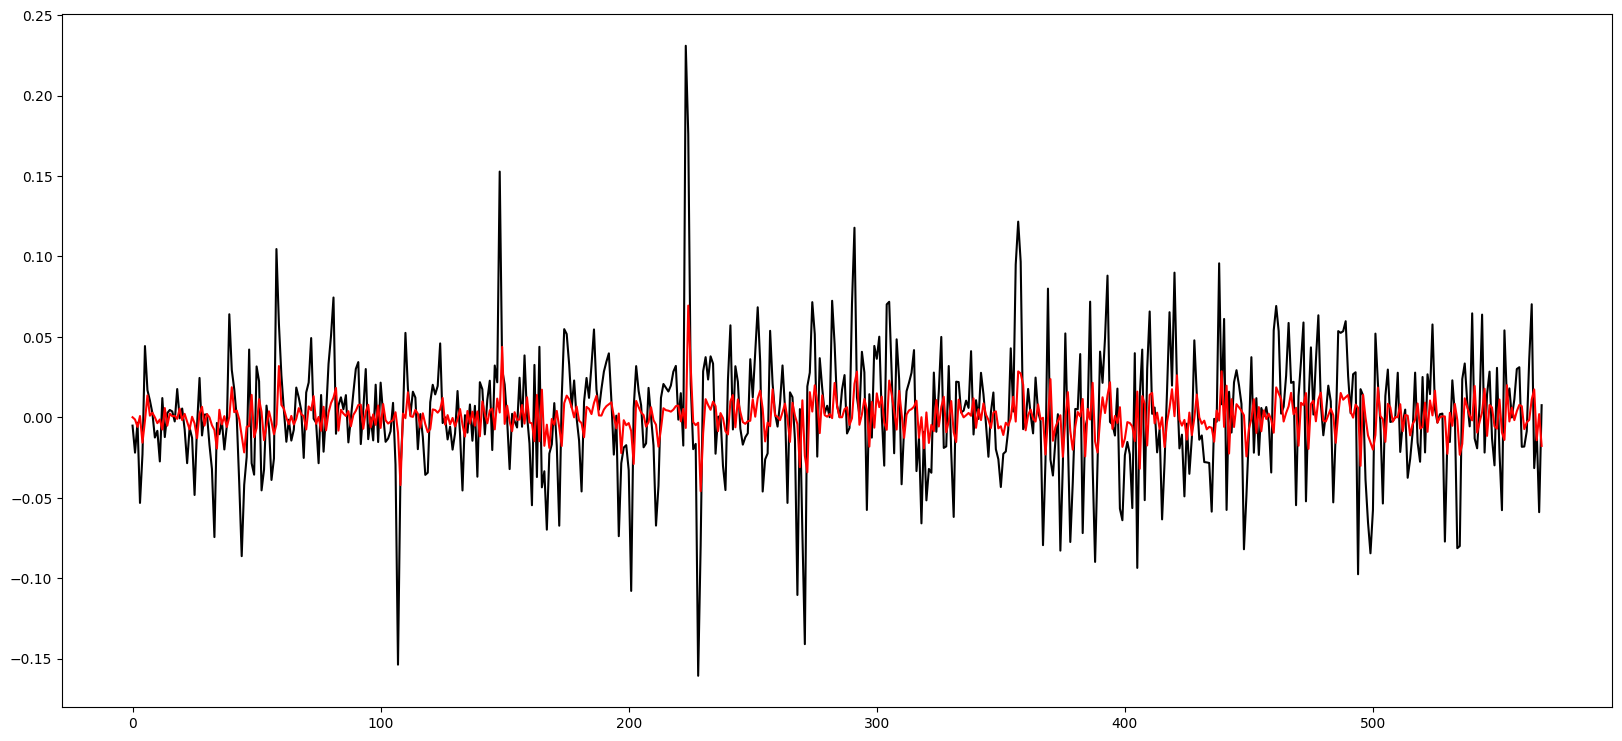

In [20]:
plt.figure(figsize=(20,9))
plt.plot(logdiffwc.values,color='black')
preds=ar1.fittedvalues
plt.plot(preds,color='red')
plt.show()

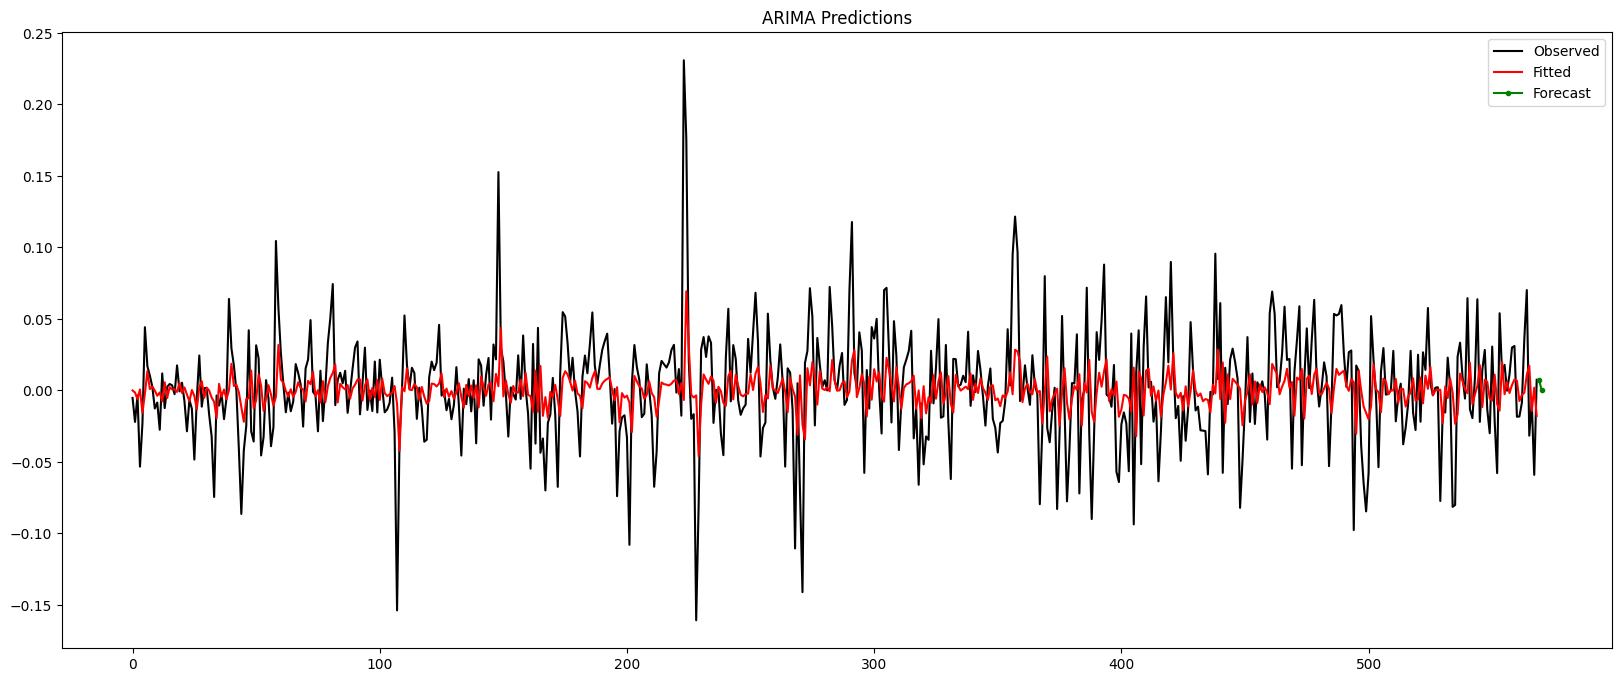

In [21]:
# Forecast next 2 steps #AI
steps = 2
forecast = ar1.forecast(steps=steps)

# Plot original series
plt.figure(figsize=(20,8))
plt.plot(logdiffwc.values, color='black', label='Observed')

# Plot fitted values
preds = ar1.fittedvalues
plt.plot(preds, color='red', label='Fitted')

# Plot forecast
forecast_index = np.arange(len(logdiffwc.values), len(logdiffwc.values) + steps)
plt.plot(forecast_index, forecast, color='green',marker='.', label='Forecast')

plt.title('ARIMA Predictions')
plt.legend()
plt.show()

SARIMA

In [22]:
ar2=SARIMAX(logdiffwc.values,order=(0,0,1),seasonal_order=(0,0,1,52),
            enforce_invertibility=False,enforce_stationarity=False).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  569
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood                 949.604
Date:                            Fri, 26 Dec 2025   AIC                          -1893.209
Time:                                    00:14:34   BIC                          -1880.476
Sample:                                         0   HQIC                         -1888.219
                                            - 569                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2915      0.033      8.711      0.000       0.226       0.357
ma.S.L52       0.0447      0.049      0.908      0.364      -0.052       0.141
sigma2         0.0015   5.35e-05     27.394      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               334.06
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.16
Prob(H) (two-sided):                  0.91   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC: -1893.209

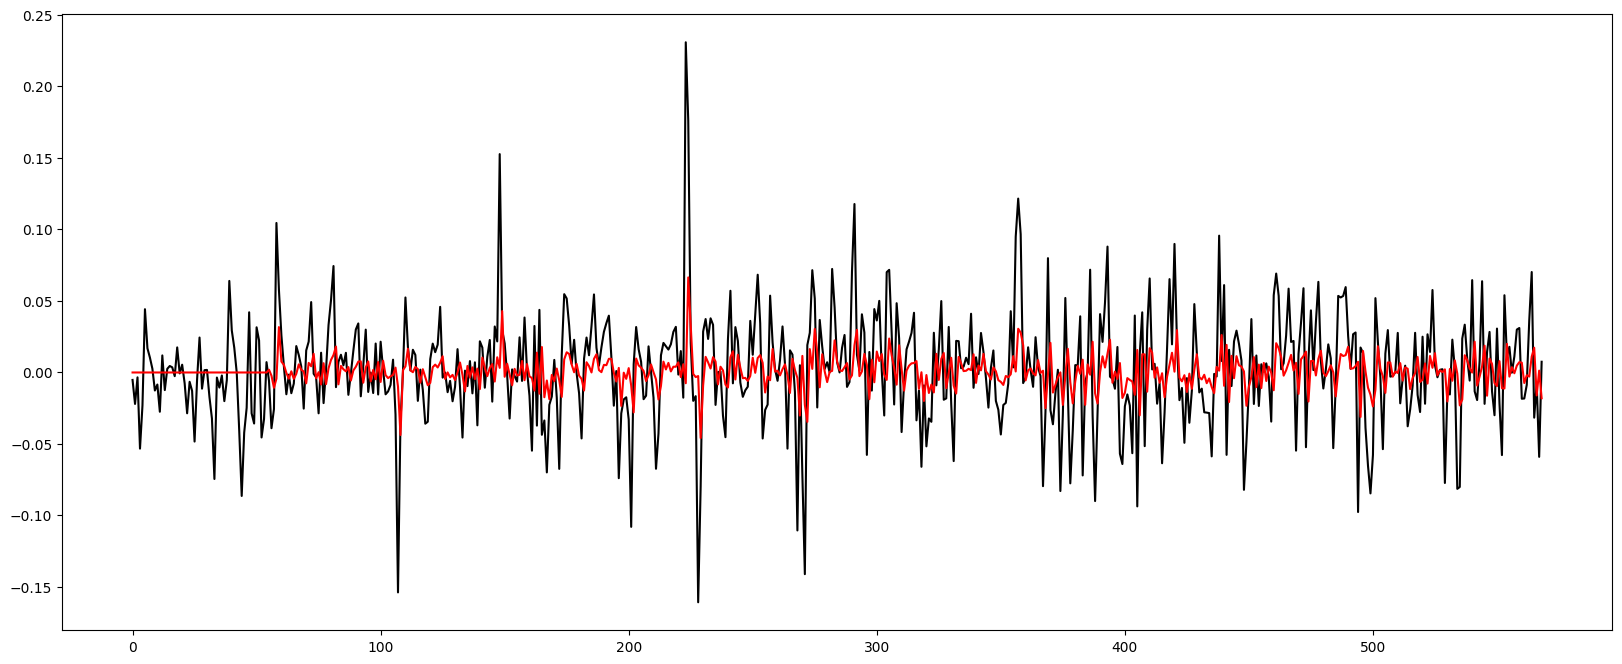

In [23]:
plt.figure(figsize=(20,8))
plt.plot(logdiffwc.values,color='black')
preds=ar2.fittedvalues
plt.plot(preds,color='red')
plt.show()

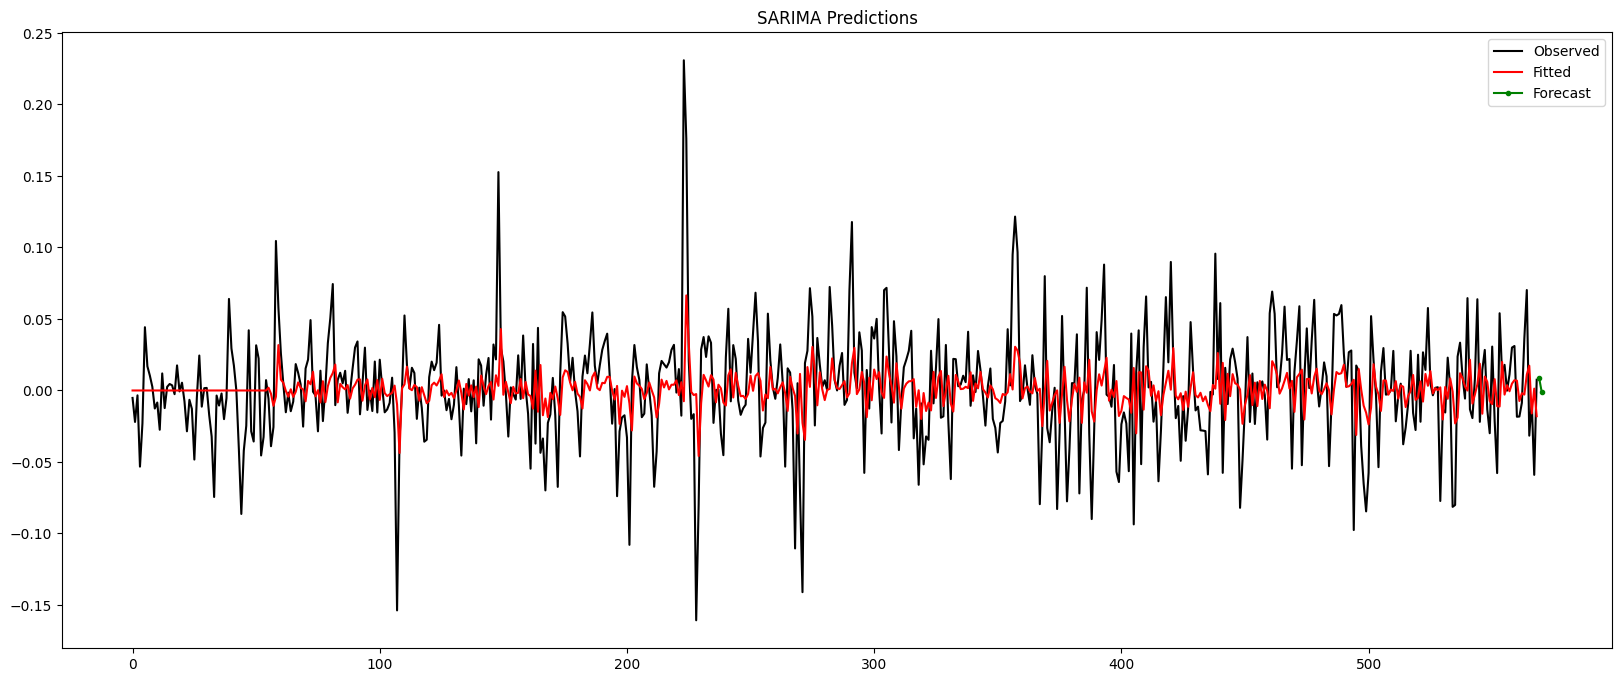

In [24]:
# Forecast next 2 steps #AI
steps = 2
forecast = ar2.forecast(steps=steps)

# Plot original series
plt.figure(figsize=(20,8))
plt.plot(logdiffwc.values, color='black', label='Observed')

# Plot fitted values
preds = ar2.fittedvalues
plt.plot(preds, color='red', label='Fitted')

# Plot forecast
forecast_index = np.arange(len(logdiffwc.values), len(logdiffwc.values) + steps)
plt.plot(forecast_index, forecast, color='green',marker='.', label='Forecast')

plt.title('SARIMA Predictions')
plt.legend()
plt.show()

We predicted based on mean reversion, now we try with volatility.

Garch

In [25]:
gar=arch_model(logdiffwc.values,
               mean='AR',
               lags=1,
               vol='Garch',
               p=1,q=1,dist='normal')
garch=gar.fit(disp='off')
garch.summary()

c:\Users\anshc\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.078
Mean Model:                        AR   Adj. R-squared:                  0.077
Vol Model:                      GARCH   Log-Likelihood:                1067.34
Distribution:                  Normal   AIC:                          -2124.68
Method:            Maximum Likelihood   BIC:                          -2102.97
                                        No. Observations:                  568
Date:                Fri, Dec 26 2025   Df Residuals:                      566
Time:                        00:14:35   Df Model:                            2
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      9.6437e-04  1.876e-03      0.514      0.607 [-2.712e-03,4.641e-03]
y[1]           0.2854  7.045e-02      4.052  5.081e-05      [  0.147,  0.424]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3559e-05  6.804e-09   1992.979      0.000 [1.355e-05,1.357e-05]
alpha[1]   5.7380e-10  7.895e-02  7.268e-09      1.000     [ -0.155,  0.155]
beta[1]        0.9916  8.055e-02     12.310  7.971e-35     [  0.834,  1.150]
============================================================================

Covariance estimator: robust
"""

AIC=-2120.25

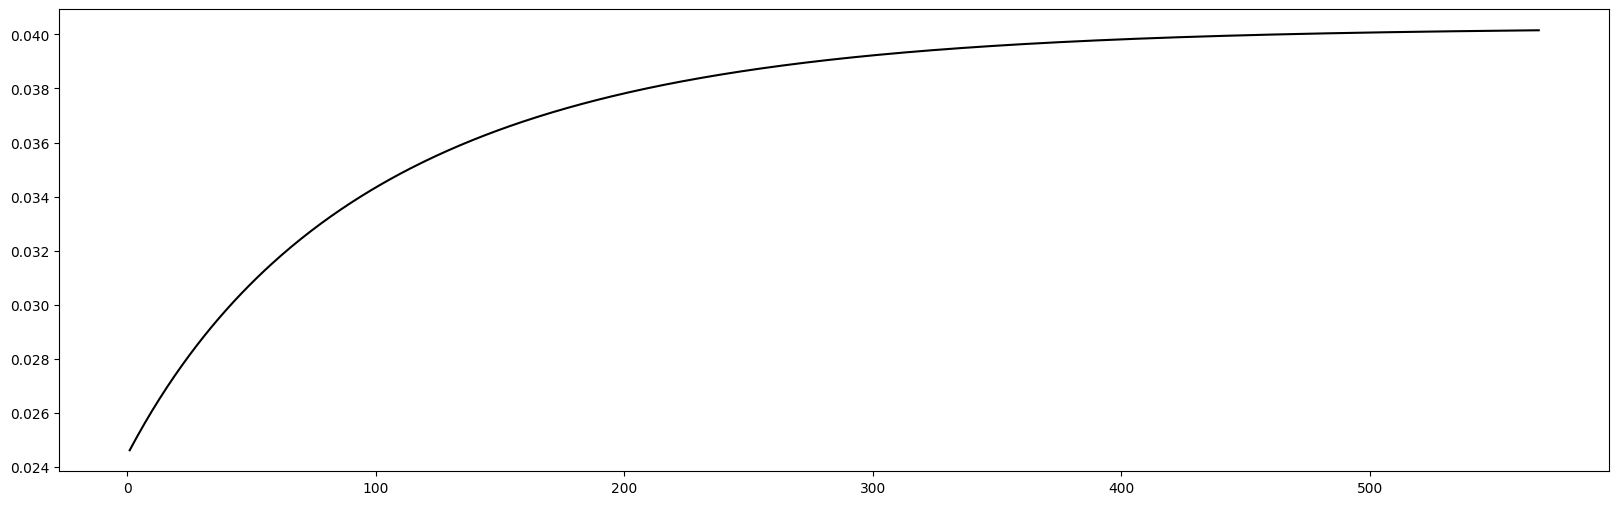

In [32]:
plt.figure(figsize=(20,6))
volatility=garch.conditional_volatility
plt.plot(volatility,color='black')
plt.show()

Reasons for taking 2 weeks for predcition in ARIMA and SARIMA:

- Memory is short.

- 1–2 weeks is the realistic horizon.

- Beyond that, forecasts collapse to zero and pretend confidence giving a constant straight line in direction of mean values.

We take 4 weeks for Garch because volitility can persist unlike short and fast memory and mean reversion resectively in ARIMA.

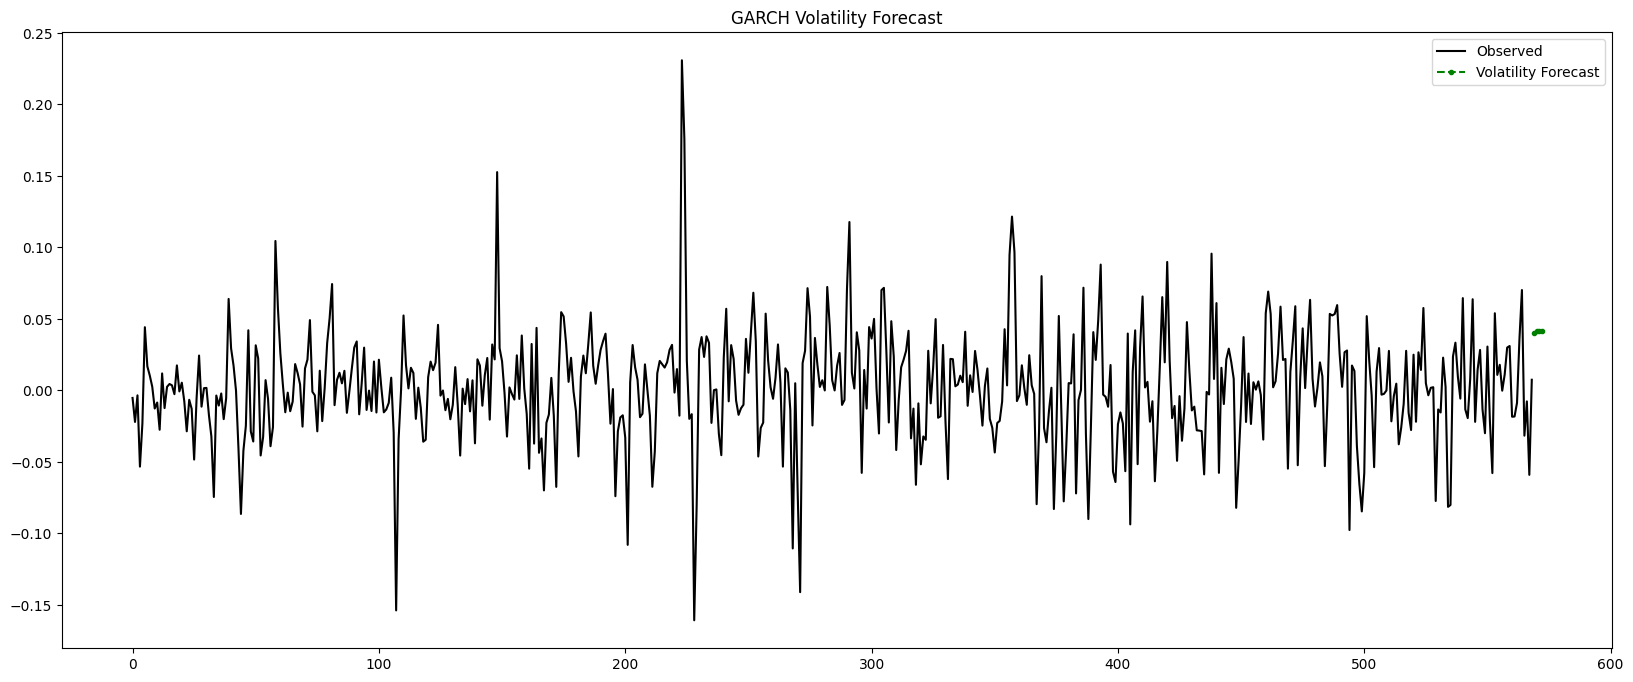

In [27]:
res = garch

# Forecast next 4 steps -AI
horizon = 4
fcst = res.forecast(horizon=horizon)

# Variance / volatility forecast 
var_fc = fcst.variance.iloc[-1].values
vol_fc = np.sqrt(var_fc)

# Plot
plt.figure(figsize=(20,8))
plt.plot(logdiffwc.values, color='black', label='Observed')

forecast_index = np.arange(len(logdiffwc), len(logdiffwc) + horizon)

plt.plot(forecast_index, vol_fc, marker='.', linestyle='--', label='Volatility Forecast',color='green')

plt.title('GARCH Volatility Forecast')
plt.legend()
plt.show()

Lets compare with the original values/signals

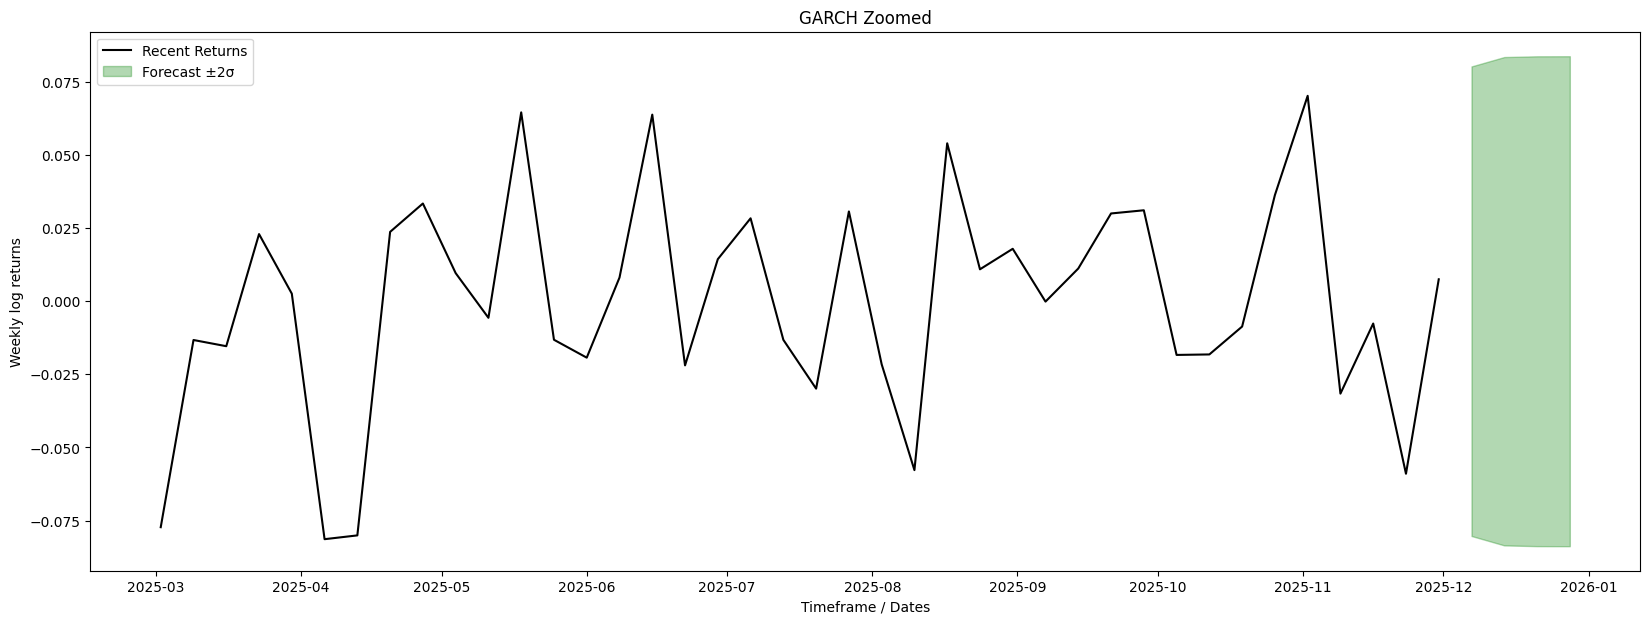

In [28]:
zoom = 40
horizon = 4

# Date index from your original series-AI
dates = logdiffwc.index

hist_dates = dates[-zoom:]
fcst_dates = pd.date_range(
    start=dates[-1],
    periods=horizon + 1,
    freq='W'
)[1:]

hist_returns = logdiffwc['weeklyr'].iloc[-zoom:]

vol_fc = np.sqrt(res.forecast(horizon=horizon).variance.iloc[-1].values)

plt.figure(figsize=(20,7))

# Historical returns
plt.plot(hist_dates, hist_returns, color='black', label='Recent Returns')

# Volatility bands
plt.fill_between(
    fcst_dates,
    -2 * vol_fc,
    2 * vol_fc,
    color='green',
    alpha=0.3,
    label='Forecast ±2σ'
)

plt.xlabel('Timeframe / Dates')
plt.ylabel('Weekly log returns')
plt.title('GARCH Zoomed')
plt.legend()
plt.show()


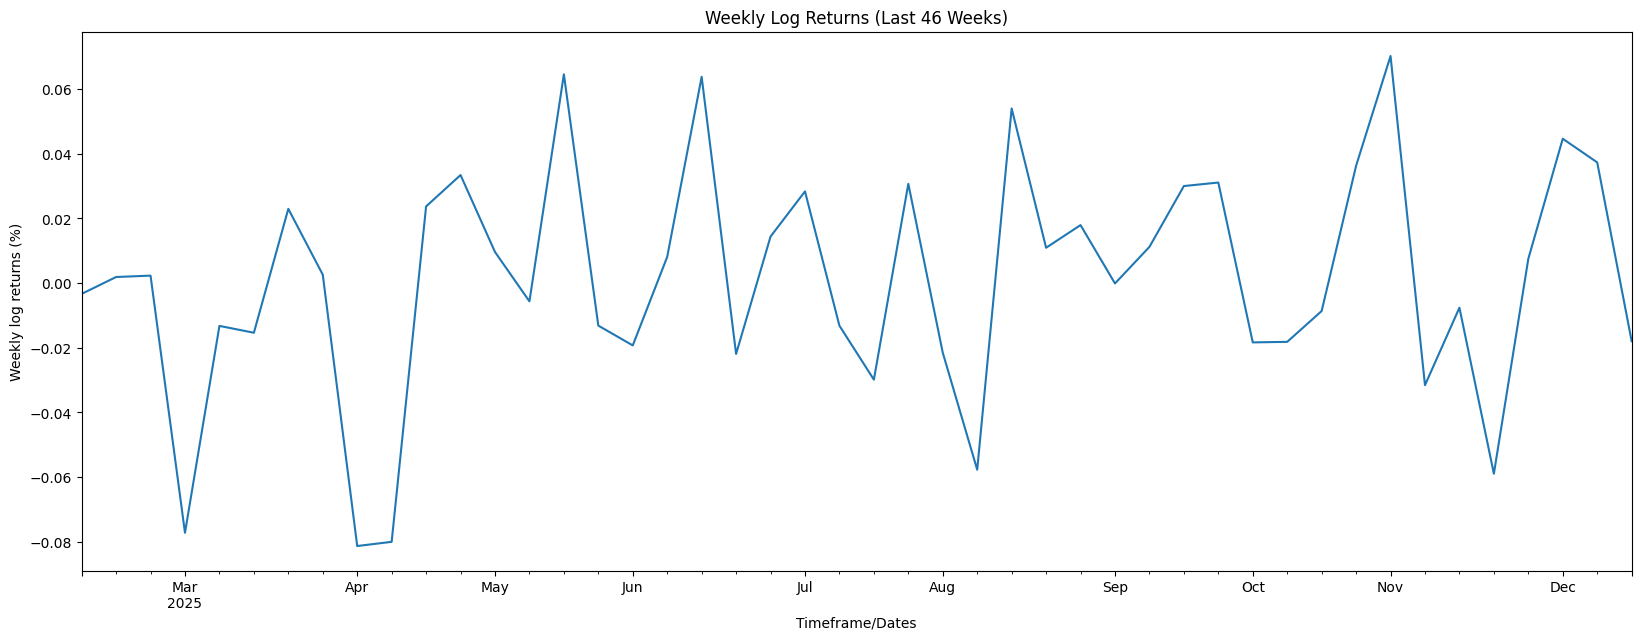

In [29]:
zoomr = 46  

plt.figure(figsize=(20,7))
week['weeklyr'].iloc[-zoomr:].plot(kind='line')
plt.xlabel('Timeframe/Dates')
plt.ylabel('Weekly log returns (%)')
plt.title(f'Weekly Log Returns (Last {zoomr} Weeks)')
plt.show()


c:\Users\anshc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


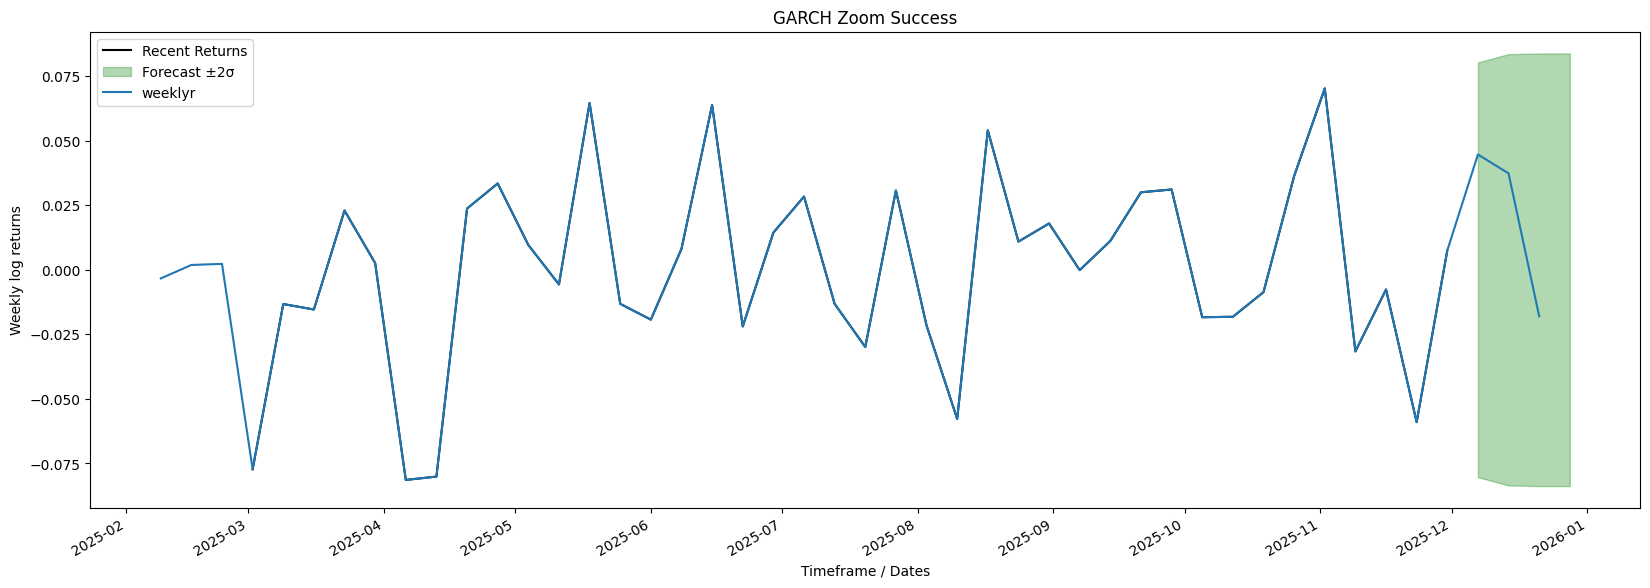

In [30]:
zoom = 40
horizon = 4

# Date index from your original series
dates = logdiffwc.index

hist_dates = dates[-zoom:]
fcst_dates = pd.date_range(
    start=dates[-1],
    periods=horizon + 1,
    freq='W'
)[1:]

hist_returns = logdiffwc['weeklyr'].iloc[-zoom:]

vol_fc = np.sqrt(res.forecast(horizon=horizon).variance.iloc[-1].values)

plt.figure(figsize=(20,7))

# Historical returns
plt.plot(hist_dates, hist_returns, color='black', label='Recent Returns')

# Volatility bands
plt.fill_between(
    fcst_dates,
    -2 * vol_fc,
    2 * vol_fc,
    color='green',
    alpha=0.3,
    label='Forecast ±2σ'
)
zoomr = 46  # last ~50 weeks
week['weeklyr'].iloc[-zoomr:].plot(kind='line')

plt.xlabel('Timeframe / Dates')
plt.ylabel('Weekly log returns')
plt.title('GARCH Zoom Success')
plt.legend()
plt.show()

Improved Graph with stable singular x and y axes along with the predicted weeks marked in blue.

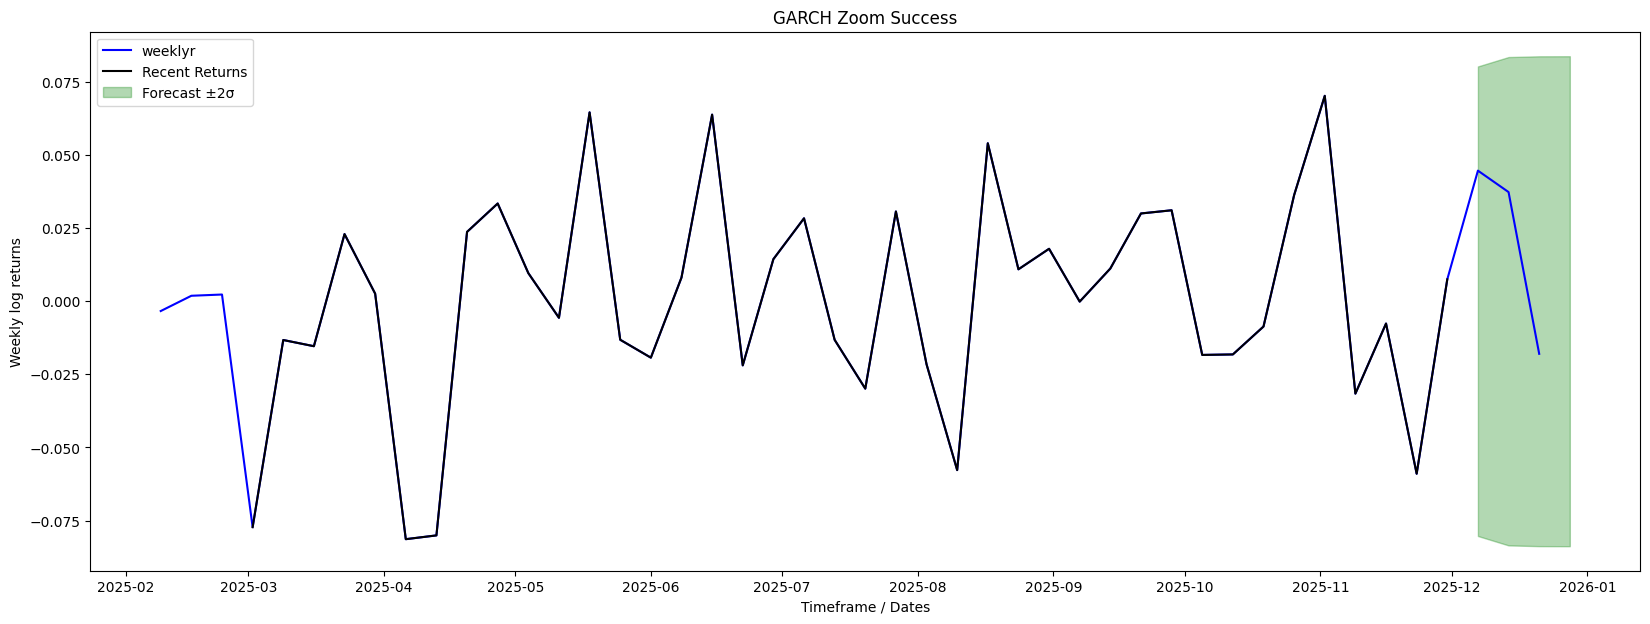

In [31]:
plt.figure(figsize=(20,7))

# Historical returns (full zoom window)
plt.plot(
    week.index[-zoomr:],
    week['weeklyr'].iloc[-zoomr:],
    color='blue',
    label='weeklyr'
)

# Recent returns (subset)
plt.plot(hist_dates, hist_returns, color='black', label='Recent Returns')

# Volatility bands
plt.fill_between(
    fcst_dates,
    -2 * vol_fc,
    2 * vol_fc,
    color='green',
    alpha=0.3,
    label='Forecast ±2σ'
)

plt.xlabel('Timeframe / Dates')
plt.ylabel('Weekly log returns')
plt.title('GARCH Zoom Success')
plt.legend()
plt.show()


Observe how values fall within -0.08 to +0.08 volatility window that Garch predicted. Look closely at the end parts in green. This shows that the future values/signals/trends fall within predicted
region for volatility.

This is much better than the modeled conditional mean that ARIMA gives us.

- ARIMA guesses direction (usually poorly).
- GARCH prices uncertainty (consistently well).